In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from tqdm import tqdm
import os
from PIL import Image

In [2]:
transform = transforms.Compose([
        transforms.RandAugment(2,5),
        transforms.ToTensor(),
        transforms.Normalize((0.25,0.25,0.25), (0.25,0.25,0.25))
    ])

In [3]:
class TrainDataset(Dataset):
    def __init__(self, root_dir='CIFAR-10\\train', transform=transform):
        self.name_list=os.listdir(root_dir)
        img_list=[]
        for i in range(10):
            img_list.extend(os.listdir(root_dir+'\\'+self.name_list[i]))
        self.image_list=img_list
        self.root_dir=root_dir
        self.namedict = {}
        for i in range(10):
            self.namedict[self.name_list[i]] = i
    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        #label=self.image_list[index].split("_")[0]
        name=self.image_list[index].split("_")[0]
        image=Image.open(self.root_dir+'\\'+name+'\\'+self.image_list[index])
        image=transform(image)
        label=self.namedict[name]
        return image, label

class TestDataset(Dataset):
    def __init__(self, root_dir='CIFAR-10\\test', transform=None):
        self.name_list=os.listdir(root_dir)
        img_list=[]
        for i in range(10):
            img_list.extend(os.listdir(root_dir+'\\'+self.name_list[i]))
        self.image_list=img_list
        self.root_dir=root_dir
        self.namedict = {}
        for i in range(10):
            self.namedict[self.name_list[i]] = i

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        #label=self.image_list[index].split("_")[0]
        name=self.image_list[index].split("_")[1]
        image=Image.open(self.root_dir+'\\'+name+'\\'+self.image_list[index])
        image=transform(image)
        label=self.namedict[name]
        return image, label

1.

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn1=nn.Sequential(
            nn.Conv2d(3, 28, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(28),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
        )
        self.cnn2=nn.Sequential(
            nn.Conv2d(28, 56, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(56),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
        )
        self.cnn3=nn.Sequential(
            nn.Conv2d(56, 136, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(136),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
        )

        
        self.fc = nn.Linear(136*4*4, 10)
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x=self.cnn1(x)
        x=self.cnn2(x)
        x=self.cnn3(x)
        x = x.view(x.size(0), -1)
        x=self.dropout(x)
        x=self.fc(x)
        
        return x


In [5]:
train_data=TrainDataset()
trainloader=torch.utils.data.DataLoader(train_data, batch_size=32,shuffle=True)
test_data=TestDataset()
testloader=torch.utils.data.DataLoader(test_data, batch_size=32,shuffle=False)

In [6]:
model_cnn= CNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cnn.to(device)
optimizer = torch.optim.Adam(model_cnn.parameters(),lr=0.001,weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

In [7]:
def train(i,num_epochs,model):
    model.train()
    acc=[]
    loss_list=[]
    for epoch in range(1):
        for images, labels in( bar :=tqdm(trainloader)):
            
            images = images.to(device)
            labels = labels.to(device)#batchsize 
            
            optimizer.zero_grad()
            
            output=model(images)
           
            loss=criterion(output, labels)
            
            loss.backward()
            optimizer.step()

    
            accuracy=(( torch.argmax(output, dim=1)==labels).sum().item())/labels.size(0)
            acc.append(accuracy)

            bar.set_description(f'epoch[{i+1:3d}/{num_epochs}]|Training')
            bar.set_postfix_str(f' loss {loss.item():.4f} accuracy {sum(acc)/len(acc) :.4f}')

            loss_list.append(loss.item())
    return sum(loss_list)/len(loss_list),sum(acc)/len(acc)
def test(model):
    model.eval()
    acc=[]
    total=[]
    loss_list=[]
    with torch.no_grad():
        
        for images, labels in( bar :=tqdm(testloader,smoothing=0.1)):
            
            images = images.to(device)
            labels = labels.to(device)#batchsize 
            
            output=model(images)
            loss=criterion(output, labels)
            
            accuracy=(( torch.argmax(output, dim=1)==labels).sum().item())#/labels.size(0)

            acc.append(accuracy)
            total.append(labels.size(0))
            loss_list.append(loss.item())
        print("accuracy: ",sum(acc)/sum(total))
    return sum(loss_list)/len(loss_list),sum(acc)/sum(total)



In [8]:
num_epochs=100
loss_cnn_train_list=[]
loss_cnn_test_list=[]
acc_cnn_train_list=[]
acc_cnn_test_list=[]
for i in range(num_epochs):
    loss_cnn_train,acc_cnn_train=train(i,num_epochs,model_cnn)
    loss_cnn_train_list.append(loss_cnn_train)
    acc_cnn_train_list.append(acc_cnn_train)

    loss_cnn_test,acc_cnn_test=test(model_cnn)
    loss_cnn_test_list.append(loss_cnn_test)
    acc_cnn_test_list.append(acc_cnn_test)


epoch[  1/100]|Training: 100%|██████████| 63/63 [00:03<00:00, 17.57it/s,  loss 2.0112 accuracy 0.2480]
100%|██████████| 13/13 [00:00<00:00, 44.18it/s]


accuracy:  0.33


epoch[  2/100]|Training: 100%|██████████| 63/63 [00:01<00:00, 36.57it/s,  loss 2.0877 accuracy 0.3447]
100%|██████████| 13/13 [00:00<00:00, 42.17it/s]


accuracy:  0.34


epoch[  3/100]|Training: 100%|██████████| 63/63 [00:01<00:00, 33.75it/s,  loss 1.9716 accuracy 0.3973]
100%|██████████| 13/13 [00:00<00:00, 39.96it/s]


accuracy:  0.3825


epoch[  4/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 29.03it/s,  loss 1.4963 accuracy 0.4449]
100%|██████████| 13/13 [00:00<00:00, 35.88it/s]


accuracy:  0.415


epoch[  5/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 23.25it/s,  loss 1.7662 accuracy 0.4797]
100%|██████████| 13/13 [00:00<00:00, 36.28it/s]


accuracy:  0.4


epoch[  6/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 23.04it/s,  loss 1.0363 accuracy 0.4936]
100%|██████████| 13/13 [00:00<00:00, 34.54it/s]


accuracy:  0.385


epoch[  7/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 22.62it/s,  loss 1.7583 accuracy 0.5253]
100%|██████████| 13/13 [00:00<00:00, 35.20it/s]


accuracy:  0.4475


epoch[  8/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 23.30it/s,  loss 1.3862 accuracy 0.5501]
100%|██████████| 13/13 [00:00<00:00, 35.68it/s]


accuracy:  0.435


epoch[  9/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 22.68it/s,  loss 1.0844 accuracy 0.5620]
100%|██████████| 13/13 [00:00<00:00, 35.68it/s]


accuracy:  0.4725


epoch[ 10/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 23.62it/s,  loss 1.5255 accuracy 0.5719]
100%|██████████| 13/13 [00:00<00:00, 37.32it/s]


accuracy:  0.455


epoch[ 11/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 23.90it/s,  loss 0.5229 accuracy 0.6032]
100%|██████████| 13/13 [00:00<00:00, 36.69it/s]


accuracy:  0.4675


epoch[ 12/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 23.89it/s,  loss 1.2283 accuracy 0.6156]
100%|██████████| 13/13 [00:00<00:00, 36.38it/s]


accuracy:  0.455


epoch[ 13/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 23.02it/s,  loss 1.3956 accuracy 0.6186]
100%|██████████| 13/13 [00:00<00:00, 36.59it/s]


accuracy:  0.4725


epoch[ 14/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 23.11it/s,  loss 0.8049 accuracy 0.6414]
100%|██████████| 13/13 [00:00<00:00, 35.88it/s]


accuracy:  0.46


epoch[ 15/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 23.20it/s,  loss 1.1212 accuracy 0.6329]
100%|██████████| 13/13 [00:00<00:00, 34.00it/s]


accuracy:  0.4725


epoch[ 16/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 22.87it/s,  loss 1.3875 accuracy 0.6617]
100%|██████████| 13/13 [00:00<00:00, 35.39it/s]


accuracy:  0.49


epoch[ 17/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 23.06it/s,  loss 0.6902 accuracy 0.6677]
100%|██████████| 13/13 [00:00<00:00, 37.22it/s]


accuracy:  0.48


epoch[ 18/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 29.33it/s,  loss 0.5876 accuracy 0.6731]
100%|██████████| 13/13 [00:00<00:00, 40.46it/s]


accuracy:  0.5325


epoch[ 19/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 28.95it/s,  loss 1.3898 accuracy 0.6786]
100%|██████████| 13/13 [00:00<00:00, 37.00it/s]


accuracy:  0.5275


epoch[ 20/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 28.80it/s,  loss 1.0134 accuracy 0.6944]
100%|██████████| 13/13 [00:00<00:00, 38.31it/s]


accuracy:  0.5375


epoch[ 21/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 29.88it/s,  loss 0.8876 accuracy 0.7148]
100%|██████████| 13/13 [00:00<00:00, 38.77it/s]


accuracy:  0.5025


epoch[ 22/100]|Training: 100%|██████████| 63/63 [00:01<00:00, 31.75it/s,  loss 0.8299 accuracy 0.7103]
100%|██████████| 13/13 [00:00<00:00, 39.72it/s]


accuracy:  0.445


epoch[ 23/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 30.17it/s,  loss 0.6513 accuracy 0.6989]
100%|██████████| 13/13 [00:00<00:00, 36.69it/s]


accuracy:  0.5175


epoch[ 24/100]|Training: 100%|██████████| 63/63 [00:01<00:00, 32.55it/s,  loss 0.7085 accuracy 0.7252]
100%|██████████| 13/13 [00:00<00:00, 40.34it/s]


accuracy:  0.51


epoch[ 25/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 29.84it/s,  loss 0.7932 accuracy 0.7158]
100%|██████████| 13/13 [00:00<00:00, 38.20it/s]


accuracy:  0.5425


epoch[ 26/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 30.24it/s,  loss 1.0264 accuracy 0.7431]
100%|██████████| 13/13 [00:00<00:00, 33.56it/s]


accuracy:  0.5075


epoch[ 27/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 25.24it/s,  loss 0.8291 accuracy 0.7257]
100%|██████████| 13/13 [00:00<00:00, 42.37it/s]


accuracy:  0.5375


epoch[ 28/100]|Training: 100%|██████████| 63/63 [00:01<00:00, 34.08it/s,  loss 0.4340 accuracy 0.7619]
100%|██████████| 13/13 [00:00<00:00, 42.58it/s]


accuracy:  0.5025


epoch[ 29/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 29.86it/s,  loss 0.7698 accuracy 0.7634]
100%|██████████| 13/13 [00:00<00:00, 39.95it/s]


accuracy:  0.5375


epoch[ 30/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 29.19it/s,  loss 0.6712 accuracy 0.7431]
100%|██████████| 13/13 [00:00<00:00, 37.70it/s]


accuracy:  0.505


epoch[ 31/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 30.87it/s,  loss 0.6799 accuracy 0.7733]
100%|██████████| 13/13 [00:00<00:00, 40.21it/s]


accuracy:  0.51


epoch[ 32/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 26.02it/s,  loss 0.4281 accuracy 0.7738]
100%|██████████| 13/13 [00:00<00:00, 36.19it/s]


accuracy:  0.5175


epoch[ 33/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 23.47it/s,  loss 0.3597 accuracy 0.7733]
100%|██████████| 13/13 [00:00<00:00, 35.78it/s]


accuracy:  0.5125


epoch[ 34/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 23.44it/s,  loss 0.9176 accuracy 0.7569]
100%|██████████| 13/13 [00:00<00:00, 35.78it/s]


accuracy:  0.52


epoch[ 35/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 23.48it/s,  loss 0.6075 accuracy 0.7803]
100%|██████████| 13/13 [00:00<00:00, 36.28it/s]


accuracy:  0.5625


epoch[ 36/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 23.08it/s,  loss 0.4766 accuracy 0.7917]
100%|██████████| 13/13 [00:00<00:00, 36.28it/s]


accuracy:  0.51


epoch[ 37/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 23.45it/s,  loss 0.5899 accuracy 0.7892]
100%|██████████| 13/13 [00:00<00:00, 36.48it/s]


accuracy:  0.54


epoch[ 38/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 23.56it/s,  loss 0.7189 accuracy 0.7892]
100%|██████████| 13/13 [00:00<00:00, 34.91it/s]


accuracy:  0.5375


epoch[ 39/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 23.37it/s,  loss 0.7534 accuracy 0.7981]
100%|██████████| 13/13 [00:00<00:00, 36.08it/s]


accuracy:  0.5425


epoch[ 40/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 22.92it/s,  loss 0.6490 accuracy 0.8016]
100%|██████████| 13/13 [00:00<00:00, 36.14it/s]


accuracy:  0.495


epoch[ 41/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 22.35it/s,  loss 0.8067 accuracy 0.7996]
100%|██████████| 13/13 [00:00<00:00, 36.18it/s]


accuracy:  0.5525


epoch[ 42/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 21.72it/s,  loss 0.7184 accuracy 0.8214]
100%|██████████| 13/13 [00:00<00:00, 32.12it/s]


accuracy:  0.53


epoch[ 43/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 26.22it/s,  loss 0.3224 accuracy 0.8110]
100%|██████████| 13/13 [00:00<00:00, 40.46it/s]


accuracy:  0.56


epoch[ 44/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 30.53it/s,  loss 0.4126 accuracy 0.8140]
100%|██████████| 13/13 [00:00<00:00, 39.72it/s]


accuracy:  0.5375


epoch[ 45/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 27.44it/s,  loss 0.7018 accuracy 0.8269]
100%|██████████| 13/13 [00:00<00:00, 28.89it/s]


accuracy:  0.5575


epoch[ 46/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 31.03it/s,  loss 0.6374 accuracy 0.8264]
100%|██████████| 13/13 [00:00<00:00, 36.79it/s]


accuracy:  0.515


epoch[ 47/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 27.94it/s,  loss 0.6028 accuracy 0.8294]
100%|██████████| 13/13 [00:00<00:00, 35.88it/s]


accuracy:  0.5775


epoch[ 48/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 27.83it/s,  loss 0.5941 accuracy 0.8155]
100%|██████████| 13/13 [00:00<00:00, 30.14it/s]


accuracy:  0.5325


epoch[ 49/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 21.13it/s,  loss 0.5299 accuracy 0.8507]
100%|██████████| 13/13 [00:00<00:00, 26.78it/s]


accuracy:  0.5575


epoch[ 50/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 21.96it/s,  loss 0.4282 accuracy 0.8452]
100%|██████████| 13/13 [00:00<00:00, 33.22it/s]


accuracy:  0.5625


epoch[ 51/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 22.64it/s,  loss 0.5559 accuracy 0.8398]
100%|██████████| 13/13 [00:00<00:00, 33.13it/s]


accuracy:  0.525


epoch[ 52/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 25.02it/s,  loss 0.6333 accuracy 0.8428]
100%|██████████| 13/13 [00:00<00:00, 34.67it/s]


accuracy:  0.5775


epoch[ 53/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 30.44it/s,  loss 0.7536 accuracy 0.8279]
100%|██████████| 13/13 [00:00<00:00, 38.44it/s]


accuracy:  0.56


epoch[ 54/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 27.72it/s,  loss 0.2622 accuracy 0.8467]
100%|██████████| 13/13 [00:00<00:00, 38.94it/s]


accuracy:  0.5475


epoch[ 55/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 29.53it/s,  loss 0.4821 accuracy 0.8676]
100%|██████████| 13/13 [00:00<00:00, 38.46it/s]


accuracy:  0.56


epoch[ 56/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 29.00it/s,  loss 0.8334 accuracy 0.8462]
100%|██████████| 13/13 [00:00<00:00, 37.55it/s]


accuracy:  0.5325


epoch[ 57/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 22.73it/s,  loss 0.4689 accuracy 0.8562]
100%|██████████| 13/13 [00:00<00:00, 29.90it/s]


accuracy:  0.575


epoch[ 58/100]|Training: 100%|██████████| 63/63 [00:03<00:00, 19.29it/s,  loss 0.5801 accuracy 0.8646]
100%|██████████| 13/13 [00:00<00:00, 35.35it/s]


accuracy:  0.57


epoch[ 59/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 24.35it/s,  loss 0.6850 accuracy 0.8472]
100%|██████████| 13/13 [00:00<00:00, 31.83it/s]


accuracy:  0.5525


epoch[ 60/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 21.46it/s,  loss 0.5988 accuracy 0.8631]
100%|██████████| 13/13 [00:00<00:00, 39.01it/s]


accuracy:  0.5825


epoch[ 61/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 25.84it/s,  loss 1.1703 accuracy 0.8636]
100%|██████████| 13/13 [00:00<00:00, 31.68it/s]


accuracy:  0.5725


epoch[ 62/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 22.06it/s,  loss 0.3811 accuracy 0.8586]
100%|██████████| 13/13 [00:00<00:00, 43.60it/s]


accuracy:  0.5575


epoch[ 63/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 22.75it/s,  loss 0.3697 accuracy 0.8690]
100%|██████████| 13/13 [00:00<00:00, 29.88it/s]


accuracy:  0.5575


epoch[ 64/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 23.78it/s,  loss 0.5130 accuracy 0.8616]
100%|██████████| 13/13 [00:00<00:00, 32.92it/s]


accuracy:  0.525


epoch[ 65/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 28.30it/s,  loss 0.2824 accuracy 0.8834]
100%|██████████| 13/13 [00:00<00:00, 32.60it/s]


accuracy:  0.5325


epoch[ 66/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 26.48it/s,  loss 0.4289 accuracy 0.8854]
100%|██████████| 13/13 [00:00<00:00, 38.10it/s]


accuracy:  0.535


epoch[ 67/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 23.35it/s,  loss 0.6216 accuracy 0.8725]
100%|██████████| 13/13 [00:00<00:00, 36.39it/s]


accuracy:  0.5625


epoch[ 68/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 23.34it/s,  loss 0.3296 accuracy 0.8844]
100%|██████████| 13/13 [00:00<00:00, 39.49it/s]


accuracy:  0.5175


epoch[ 69/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 21.32it/s,  loss 0.4088 accuracy 0.8745]
100%|██████████| 13/13 [00:00<00:00, 41.31it/s]


accuracy:  0.535


epoch[ 70/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 22.04it/s,  loss 0.2260 accuracy 0.8844]
100%|██████████| 13/13 [00:00<00:00, 33.39it/s]


accuracy:  0.5475


epoch[ 71/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 26.28it/s,  loss 0.4902 accuracy 0.8576]
100%|██████████| 13/13 [00:00<00:00, 32.06it/s]


accuracy:  0.545


epoch[ 72/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 23.70it/s,  loss 0.4359 accuracy 0.8889]
100%|██████████| 13/13 [00:00<00:00, 30.21it/s]


accuracy:  0.5675


epoch[ 73/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 26.08it/s,  loss 0.9636 accuracy 0.8864]
100%|██████████| 13/13 [00:00<00:00, 34.91it/s]


accuracy:  0.59


epoch[ 74/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 25.82it/s,  loss 0.3959 accuracy 0.8760]
100%|██████████| 13/13 [00:00<00:00, 24.92it/s]


accuracy:  0.5175


epoch[ 75/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 22.67it/s,  loss 0.3052 accuracy 0.8834]
100%|██████████| 13/13 [00:00<00:00, 38.66it/s]


accuracy:  0.545


epoch[ 76/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 25.94it/s,  loss 0.4509 accuracy 0.8914]
100%|██████████| 13/13 [00:00<00:00, 40.41it/s]


accuracy:  0.565


epoch[ 77/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 27.05it/s,  loss 0.4184 accuracy 0.8904]
100%|██████████| 13/13 [00:00<00:00, 35.87it/s]


accuracy:  0.57


epoch[ 78/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 15.53it/s,  loss 0.3328 accuracy 0.8824]
100%|██████████| 13/13 [00:00<00:00, 33.35it/s]


accuracy:  0.5225


epoch[ 79/100]|Training: 100%|██████████| 63/63 [00:03<00:00, 19.55it/s,  loss 0.5424 accuracy 0.8919]
100%|██████████| 13/13 [00:00<00:00, 31.71it/s]


accuracy:  0.595


epoch[ 80/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 23.05it/s,  loss 0.1627 accuracy 0.8973]
100%|██████████| 13/13 [00:00<00:00, 29.00it/s]


accuracy:  0.5475


epoch[ 81/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 23.68it/s,  loss 0.1917 accuracy 0.9058]
100%|██████████| 13/13 [00:00<00:00, 31.87it/s]


accuracy:  0.5875


epoch[ 82/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 24.55it/s,  loss 1.1175 accuracy 0.8973]
100%|██████████| 13/13 [00:00<00:00, 24.78it/s]


accuracy:  0.565


epoch[ 83/100]|Training: 100%|██████████| 63/63 [00:03<00:00, 17.59it/s,  loss 0.1838 accuracy 0.8983]
100%|██████████| 13/13 [00:00<00:00, 31.04it/s]


accuracy:  0.5725


epoch[ 84/100]|Training: 100%|██████████| 63/63 [00:03<00:00, 19.53it/s,  loss 0.0729 accuracy 0.9117]
100%|██████████| 13/13 [00:00<00:00, 41.00it/s]


accuracy:  0.55


epoch[ 85/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 25.37it/s,  loss 0.3109 accuracy 0.9087]
100%|██████████| 13/13 [00:00<00:00, 36.32it/s]


accuracy:  0.59


epoch[ 86/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 25.49it/s,  loss 0.3706 accuracy 0.8929]
100%|██████████| 13/13 [00:00<00:00, 33.43it/s]


accuracy:  0.525


epoch[ 87/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 22.68it/s,  loss 0.0850 accuracy 0.8904]
100%|██████████| 13/13 [00:00<00:00, 30.93it/s]


accuracy:  0.5425


epoch[ 88/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 22.09it/s,  loss 0.0996 accuracy 0.9077]
100%|██████████| 13/13 [00:00<00:00, 35.90it/s]


accuracy:  0.5925


epoch[ 89/100]|Training: 100%|██████████| 63/63 [00:03<00:00, 17.12it/s,  loss 0.0488 accuracy 0.9003]
100%|██████████| 13/13 [00:00<00:00, 33.30it/s]


accuracy:  0.565


epoch[ 90/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 25.88it/s,  loss 0.2377 accuracy 0.8929]
100%|██████████| 13/13 [00:00<00:00, 28.31it/s]


accuracy:  0.5775


epoch[ 91/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 28.06it/s,  loss 0.2655 accuracy 0.8929]
100%|██████████| 13/13 [00:00<00:00, 31.17it/s]


accuracy:  0.565


epoch[ 92/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 24.18it/s,  loss 0.3044 accuracy 0.9013]
100%|██████████| 13/13 [00:00<00:00, 28.47it/s]


accuracy:  0.52


epoch[ 93/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 27.60it/s,  loss 0.3670 accuracy 0.9018]
100%|██████████| 13/13 [00:00<00:00, 29.27it/s]


accuracy:  0.5675


epoch[ 94/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 27.04it/s,  loss 0.2969 accuracy 0.9246]
100%|██████████| 13/13 [00:00<00:00, 31.44it/s]


accuracy:  0.6


epoch[ 95/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 28.40it/s,  loss 0.0656 accuracy 0.9107]
100%|██████████| 13/13 [00:00<00:00, 30.33it/s]


accuracy:  0.53


epoch[ 96/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 27.19it/s,  loss 0.3067 accuracy 0.9196]
100%|██████████| 13/13 [00:00<00:00, 31.95it/s]


accuracy:  0.585


epoch[ 97/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 29.28it/s,  loss 0.1858 accuracy 0.9236]
100%|██████████| 13/13 [00:00<00:00, 29.09it/s]


accuracy:  0.5575


epoch[ 98/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 28.05it/s,  loss 0.4835 accuracy 0.9191]
100%|██████████| 13/13 [00:00<00:00, 28.04it/s]


accuracy:  0.5475


epoch[ 99/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 27.81it/s,  loss 0.1628 accuracy 0.9122]
100%|██████████| 13/13 [00:00<00:00, 31.42it/s]


accuracy:  0.565


epoch[100/100]|Training: 100%|██████████| 63/63 [00:02<00:00, 27.41it/s,  loss 0.3622 accuracy 0.9077]
100%|██████████| 13/13 [00:00<00:00, 32.71it/s]

accuracy:  0.5125


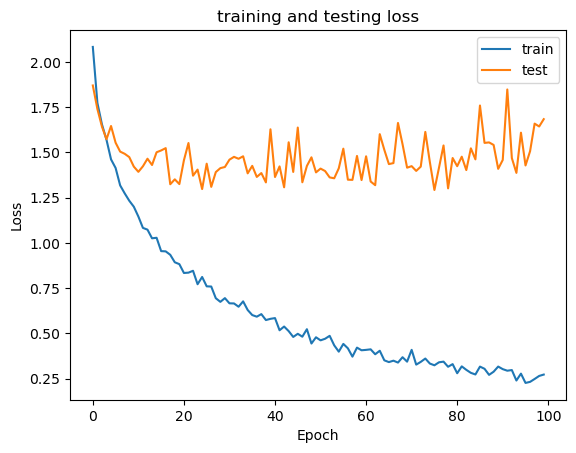

In [9]:
import matplotlib.pyplot as plt


y = loss_cnn_train_list
y_test=loss_cnn_test_list
plt.title('training and testing loss')
plt.plot(y,label='train')
plt.plot(y_test, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

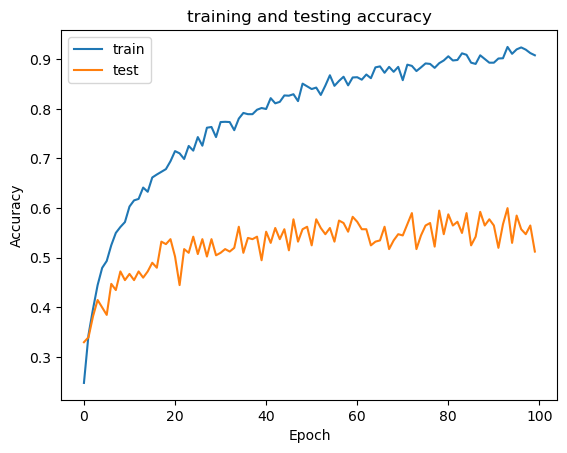

In [10]:
y =acc_cnn_train_list
y_test=acc_cnn_test_list
plt.title('training and testing accuracy')
plt.plot(y,label='train')
plt.plot(y_test, label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

2.(a)

In [11]:
class Resnet18(nn.Module):
        def __init__(self):
            super(Resnet18, self).__init__()
            self.cov1=nn.Sequential(
                 nn.Conv2d(3,64,3,1,1),
                 nn.BatchNorm2d(64),
                 nn.ReLU(),
                 nn.AvgPool2d(2,2)

            )
            self.res=nn.Sequential(
                 nn.Conv2d(64,64,3,1,1),
                 nn.BatchNorm2d(64),
                 nn.ReLU(),
                 nn.Conv2d(64,64,3,1,1),
                 nn.BatchNorm2d(64),
                 nn.ReLU()
            )
            self.res2=nn.Sequential(
                 nn.Conv2d(64,128,3,2,1),
                 nn.BatchNorm2d(128),
                 nn.ReLU(),
                 nn.Conv2d(128,128,3,1,1),
                 nn.BatchNorm2d(128),
                 nn.ReLU()
            )
            self.res3=nn.Sequential(
                 nn.Conv2d(128,128,3,1,1),
                 nn.BatchNorm2d(128),
                 nn.ReLU(),
                 nn.Conv2d(128,128,3,1,1),
                 nn.BatchNorm2d(128),
                 nn.ReLU()
            )
            self.res4=nn.Sequential(
                 nn.Conv2d(128,256,3,2,1),
                 nn.BatchNorm2d(256),
                 nn.ReLU(),
                 nn.Conv2d(256,256,3,1,1),
                 nn.BatchNorm2d(256),
                 nn.ReLU()
            )
            self.res5=nn.Sequential(
                 nn.Conv2d(256,256,3,1,1),
                 nn.BatchNorm2d(256),
                 nn.ReLU(),
                 nn.Conv2d(256,256,3,1,1),
                 nn.BatchNorm2d(256),
                 nn.ReLU()
            )
            self.res6=nn.Sequential(
                 nn.Conv2d(256,512,3,2,1),
                 nn.BatchNorm2d(512),
                 nn.ReLU(),
                 nn.Conv2d(512,512,3,1,1),
                 nn.BatchNorm2d(512),
                 nn.ReLU()
            )
            self.res7=nn.Sequential(
                 nn.Conv2d(512,512,3,1,1),
                 nn.BatchNorm2d(512),
                 nn.ReLU(),
                 
                 nn.Conv2d(512,512,3,1,1),
                 nn.BatchNorm2d(512),
                 nn.ReLU(),
                 nn.AvgPool2d(2,2)
            )
            self.change_shape1=nn.Sequential(
                 nn.Conv2d(64,128,3,2,1),
                 nn.BatchNorm2d(128)
            )
            self.change_shape2=nn.Sequential(
                 nn.Conv2d(128,256,3,2,1),
                 nn.BatchNorm2d(256)
            )
            self.change_shape3=nn.Sequential(
                 nn.Conv2d(256,512,3,2,1),
                 nn.BatchNorm2d(512),
                 
            )
            self.change_shape4=nn.Sequential(
                 nn.Conv2d(512,512,3,2,1),
                 nn.BatchNorm2d(512),
                 
            )
            
            self.fc=nn.Sequential(
                 nn.Dropout(0.2),
                 nn.Linear(512,10),

            )
        def forward(self, x):
            x=self.cov1(x)
            #layer1
            cut=x
            x=self.res(x)
            x=x+cut
            x=F.relu(x)
            cut=x
            x=self.res(x)
            x=x+cut
            x=F.relu(x)
            cut=x
            #print('layer1 output:',cut.shape)
            #layer2
            x=self.res2(x)
            cut=self.change_shape1(cut)
            x=x+cut
            x=F.relu(x)
            cut=x
            x=self.res3(x)
            x=x+cut
            x=F.relu(x)
            cut=x
            #print('layer2 output:',cut.shape)
            #layer3
            x=self.res4(x)
            cut=self.change_shape2(cut)
            x=x+cut
            x=F.relu(x)
            cut=x
            x=self.res5(x)
            x=x+cut
            x=F.relu(x)
            cut=x
            #print('layer3 output:',cut.shape)
            #layer4
            x=self.res6(x)
            cut=self.change_shape3(cut)
            x=x+cut
            x=F.relu(x)
            cut=x
            x=self.res7(x)
            cut=self.change_shape4(cut)
            x=x+cut
            x=F.relu(x)
            #print('layer4 output:',cut.shape)
            ##fc
            x=x.view(x.size(0),-1)
            x=self.fc(x)

            return x

In [12]:
model_res= Resnet18()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_res.to(device)
optimizer = torch.optim.Adam(model_res.parameters(),lr=0.001,weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

In [13]:
num_epochs=100
loss_res_train_list=[]
loss_res_test_list=[]
acc_res_train_list=[]
acc_res_test_list=[]
for i in range(num_epochs):
    loss_res_train,acc_res_train=train(i,num_epochs,model_res)
    loss_res_train_list.append(loss_res_train)
    acc_res_train_list.append(acc_res_train)

    loss_res_test,acc_res_test=test(model_res)
    loss_res_test_list.append(loss_res_test)
    acc_res_test_list.append(acc_res_test)
    

epoch[  1/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.25it/s,  loss 2.1068 accuracy 0.2118]
100%|██████████| 13/13 [00:00<00:00, 23.09it/s]


accuracy:  0.2125


epoch[  2/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.19it/s,  loss 1.7278 accuracy 0.2842]
100%|██████████| 13/13 [00:00<00:00, 22.93it/s]


accuracy:  0.25


epoch[  3/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.20it/s,  loss 1.9999 accuracy 0.3388]
100%|██████████| 13/13 [00:00<00:00, 21.46it/s]


accuracy:  0.315


epoch[  4/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.20it/s,  loss 1.9627 accuracy 0.3641]
100%|██████████| 13/13 [00:00<00:00, 21.43it/s]


accuracy:  0.335


epoch[  5/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.28it/s,  loss 1.7065 accuracy 0.4102]
100%|██████████| 13/13 [00:00<00:00, 21.80it/s]


accuracy:  0.295


epoch[  6/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.24it/s,  loss 1.8278 accuracy 0.4340]
100%|██████████| 13/13 [00:00<00:00, 22.33it/s]


accuracy:  0.3125


epoch[  7/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.28it/s,  loss 1.7830 accuracy 0.4628]
100%|██████████| 13/13 [00:00<00:00, 22.77it/s]


accuracy:  0.3275


epoch[  8/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.26it/s,  loss 1.8853 accuracy 0.4980]
100%|██████████| 13/13 [00:00<00:00, 22.05it/s]


accuracy:  0.38


epoch[  9/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.28it/s,  loss 1.4589 accuracy 0.5337]
100%|██████████| 13/13 [00:00<00:00, 22.41it/s]


accuracy:  0.425


epoch[ 10/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.34it/s,  loss 0.9560 accuracy 0.5635]
100%|██████████| 13/13 [00:00<00:00, 22.81it/s]


accuracy:  0.4


epoch[ 11/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.27it/s,  loss 1.2410 accuracy 0.6076]
100%|██████████| 13/13 [00:00<00:00, 22.77it/s]


accuracy:  0.34


epoch[ 12/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.35it/s,  loss 1.8684 accuracy 0.6195]
100%|██████████| 13/13 [00:00<00:00, 23.58it/s]


accuracy:  0.3825


epoch[ 13/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.36it/s,  loss 1.3987 accuracy 0.6726]
100%|██████████| 13/13 [00:00<00:00, 23.38it/s]


accuracy:  0.365


epoch[ 14/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.20it/s,  loss 0.5440 accuracy 0.6885]
100%|██████████| 13/13 [00:00<00:00, 23.19it/s]


accuracy:  0.425


epoch[ 15/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.33it/s,  loss 1.0123 accuracy 0.7282]
100%|██████████| 13/13 [00:00<00:00, 22.29it/s]


accuracy:  0.37


epoch[ 16/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.28it/s,  loss 0.9432 accuracy 0.7679]
100%|██████████| 13/13 [00:00<00:00, 22.97it/s]


accuracy:  0.365


epoch[ 17/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.24it/s,  loss 1.2638 accuracy 0.7574]
100%|██████████| 13/13 [00:00<00:00, 24.07it/s]


accuracy:  0.395


epoch[ 18/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.27it/s,  loss 0.6261 accuracy 0.7852]
100%|██████████| 13/13 [00:00<00:00, 22.93it/s]


accuracy:  0.425


epoch[ 19/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.28it/s,  loss 1.0099 accuracy 0.8313]
100%|██████████| 13/13 [00:00<00:00, 22.67it/s]


accuracy:  0.3825


epoch[ 20/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.24it/s,  loss 0.4900 accuracy 0.8413]
100%|██████████| 13/13 [00:00<00:00, 22.34it/s]


accuracy:  0.435


epoch[ 21/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.24it/s,  loss 0.5464 accuracy 0.8676]
100%|██████████| 13/13 [00:00<00:00, 21.14it/s]


accuracy:  0.445


epoch[ 22/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.22it/s,  loss 0.1178 accuracy 0.8790]
100%|██████████| 13/13 [00:00<00:00, 22.42it/s]


accuracy:  0.4275


epoch[ 23/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.22it/s,  loss 0.7488 accuracy 0.8666]
100%|██████████| 13/13 [00:00<00:00, 21.77it/s]


accuracy:  0.47


epoch[ 24/100]|Training: 100%|██████████| 63/63 [00:08<00:00,  7.09it/s,  loss 0.4194 accuracy 0.8805]
100%|██████████| 13/13 [00:00<00:00, 22.36it/s]


accuracy:  0.4425


epoch[ 25/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.22it/s,  loss 0.1678 accuracy 0.9191]
100%|██████████| 13/13 [00:00<00:00, 23.08it/s]


accuracy:  0.44


epoch[ 26/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.32it/s,  loss 0.0947 accuracy 0.9082]
100%|██████████| 13/13 [00:00<00:00, 22.53it/s]


accuracy:  0.4225


epoch[ 27/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.33it/s,  loss 0.0625 accuracy 0.9137]
100%|██████████| 13/13 [00:00<00:00, 20.00it/s]


accuracy:  0.4525


epoch[ 28/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.28it/s,  loss 0.3173 accuracy 0.9107]
100%|██████████| 13/13 [00:00<00:00, 22.31it/s]


accuracy:  0.4525


epoch[ 29/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.24it/s,  loss 0.1070 accuracy 0.9172]
100%|██████████| 13/13 [00:00<00:00, 18.58it/s]


accuracy:  0.445


epoch[ 30/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.28it/s,  loss 0.3994 accuracy 0.9172]
100%|██████████| 13/13 [00:00<00:00, 23.58it/s]


accuracy:  0.44


epoch[ 31/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.36it/s,  loss 0.2180 accuracy 0.9221]
100%|██████████| 13/13 [00:00<00:00, 23.05it/s]


accuracy:  0.4575


epoch[ 32/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.31it/s,  loss 0.2338 accuracy 0.9191]
100%|██████████| 13/13 [00:00<00:00, 22.01it/s]


accuracy:  0.455


epoch[ 33/100]|Training: 100%|██████████| 63/63 [00:08<00:00,  7.21it/s,  loss 0.3761 accuracy 0.9271]
100%|██████████| 13/13 [00:00<00:00, 22.57it/s]


accuracy:  0.4675


epoch[ 34/100]|Training: 100%|██████████| 63/63 [00:07<00:00,  8.18it/s,  loss 0.0619 accuracy 0.9226]
100%|██████████| 13/13 [00:00<00:00, 21.32it/s]


accuracy:  0.43


epoch[ 35/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.94it/s,  loss 0.5167 accuracy 0.9231]
100%|██████████| 13/13 [00:00<00:00, 22.54it/s]


accuracy:  0.46


epoch[ 36/100]|Training: 100%|██████████| 63/63 [00:08<00:00,  7.76it/s,  loss 0.2293 accuracy 0.9454]
100%|██████████| 13/13 [00:00<00:00, 23.36it/s]


accuracy:  0.475


epoch[ 37/100]|Training: 100%|██████████| 63/63 [00:08<00:00,  7.26it/s,  loss 0.3212 accuracy 0.9459]
100%|██████████| 13/13 [00:00<00:00, 22.25it/s]


accuracy:  0.49


epoch[ 38/100]|Training: 100%|██████████| 63/63 [00:07<00:00,  8.10it/s,  loss 0.0622 accuracy 0.9420]
100%|██████████| 13/13 [00:00<00:00, 24.32it/s]


accuracy:  0.4325


epoch[ 39/100]|Training: 100%|██████████| 63/63 [00:07<00:00,  8.35it/s,  loss 0.4018 accuracy 0.9370]
100%|██████████| 13/13 [00:00<00:00, 24.56it/s]


accuracy:  0.435


epoch[ 40/100]|Training: 100%|██████████| 63/63 [00:08<00:00,  7.38it/s,  loss 0.1534 accuracy 0.9464]
100%|██████████| 13/13 [00:00<00:00, 22.15it/s]


accuracy:  0.4225


epoch[ 41/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.66it/s,  loss 0.0240 accuracy 0.9489]
100%|██████████| 13/13 [00:00<00:00, 22.07it/s]


accuracy:  0.4275


epoch[ 42/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.64it/s,  loss 0.0049 accuracy 0.9563]
100%|██████████| 13/13 [00:00<00:00, 21.95it/s]


accuracy:  0.46


epoch[ 43/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.49it/s,  loss 0.2287 accuracy 0.9410]
100%|██████████| 13/13 [00:00<00:00, 22.77it/s]


accuracy:  0.425


epoch[ 44/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.58it/s,  loss 0.3333 accuracy 0.9375]
100%|██████████| 13/13 [00:00<00:00, 21.03it/s]


accuracy:  0.4825


epoch[ 45/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.60it/s,  loss 0.0338 accuracy 0.9494]
100%|██████████| 13/13 [00:00<00:00, 22.73it/s]


accuracy:  0.475


epoch[ 46/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.64it/s,  loss 0.3232 accuracy 0.9439]
100%|██████████| 13/13 [00:00<00:00, 22.32it/s]


accuracy:  0.475


epoch[ 47/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.35it/s,  loss 0.3067 accuracy 0.9375]
100%|██████████| 13/13 [00:00<00:00, 22.22it/s]


accuracy:  0.4825


epoch[ 48/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.38it/s,  loss 0.4645 accuracy 0.9524]
100%|██████████| 13/13 [00:00<00:00, 20.15it/s]


accuracy:  0.4775


epoch[ 49/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.79it/s,  loss 0.0076 accuracy 0.9459]
100%|██████████| 13/13 [00:00<00:00, 22.40it/s]


accuracy:  0.4975


epoch[ 50/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.41it/s,  loss 0.0268 accuracy 0.9509]
100%|██████████| 13/13 [00:00<00:00, 23.29it/s]


accuracy:  0.4825


epoch[ 51/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.58it/s,  loss 0.0703 accuracy 0.9549]
100%|██████████| 13/13 [00:00<00:00, 22.03it/s]


accuracy:  0.4925


epoch[ 52/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.90it/s,  loss 0.1416 accuracy 0.9534]
100%|██████████| 13/13 [00:00<00:00, 21.76it/s]


accuracy:  0.46


epoch[ 53/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.41it/s,  loss 0.2446 accuracy 0.9425]
100%|██████████| 13/13 [00:00<00:00, 23.34it/s]


accuracy:  0.4175


epoch[ 54/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.38it/s,  loss 0.3009 accuracy 0.9444]
100%|██████████| 13/13 [00:00<00:00, 21.47it/s]


accuracy:  0.4525


epoch[ 55/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.26it/s,  loss 0.0445 accuracy 0.9514]
100%|██████████| 13/13 [00:00<00:00, 17.53it/s]


accuracy:  0.4775


epoch[ 56/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.39it/s,  loss 0.0064 accuracy 0.9539]
100%|██████████| 13/13 [00:00<00:00, 22.21it/s]


accuracy:  0.46


epoch[ 57/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.51it/s,  loss 0.0440 accuracy 0.9524]
100%|██████████| 13/13 [00:00<00:00, 20.18it/s]


accuracy:  0.4625


epoch[ 58/100]|Training: 100%|██████████| 63/63 [00:08<00:00,  7.00it/s,  loss 0.3626 accuracy 0.9568]
100%|██████████| 13/13 [00:00<00:00, 21.84it/s]


accuracy:  0.51


epoch[ 59/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.96it/s,  loss 0.1204 accuracy 0.9638]
100%|██████████| 13/13 [00:00<00:00, 22.83it/s]


accuracy:  0.465


epoch[ 60/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.79it/s,  loss 0.1223 accuracy 0.9613]
100%|██████████| 13/13 [00:00<00:00, 22.72it/s]


accuracy:  0.4475


epoch[ 61/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.82it/s,  loss 0.0629 accuracy 0.9509]
100%|██████████| 13/13 [00:00<00:00, 21.06it/s]


accuracy:  0.4775


epoch[ 62/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.56it/s,  loss 0.0200 accuracy 0.9568]
100%|██████████| 13/13 [00:00<00:00, 19.79it/s]


accuracy:  0.46


epoch[ 63/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.67it/s,  loss 0.0488 accuracy 0.9683]
100%|██████████| 13/13 [00:00<00:00, 22.10it/s]


accuracy:  0.4775


epoch[ 64/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.72it/s,  loss 0.3700 accuracy 0.9722]
100%|██████████| 13/13 [00:00<00:00, 21.47it/s]


accuracy:  0.4825


epoch[ 65/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.57it/s,  loss 0.0163 accuracy 0.9554]
100%|██████████| 13/13 [00:00<00:00, 22.47it/s]


accuracy:  0.475


epoch[ 66/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.64it/s,  loss 0.0132 accuracy 0.9583]
100%|██████████| 13/13 [00:00<00:00, 22.32it/s]


accuracy:  0.475


epoch[ 67/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.61it/s,  loss 0.0656 accuracy 0.9633]
100%|██████████| 13/13 [00:00<00:00, 21.18it/s]


accuracy:  0.46


epoch[ 68/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.78it/s,  loss 0.0878 accuracy 0.9539]
100%|██████████| 13/13 [00:00<00:00, 21.30it/s]


accuracy:  0.4575


epoch[ 69/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.93it/s,  loss 0.0339 accuracy 0.9608]
100%|██████████| 13/13 [00:00<00:00, 22.89it/s]


accuracy:  0.4575


epoch[ 70/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.75it/s,  loss 0.2352 accuracy 0.9673]
100%|██████████| 13/13 [00:00<00:00, 21.91it/s]


accuracy:  0.4425


epoch[ 71/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.66it/s,  loss 0.0678 accuracy 0.9618]
100%|██████████| 13/13 [00:00<00:00, 19.11it/s]


accuracy:  0.4925


epoch[ 72/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.55it/s,  loss 0.4014 accuracy 0.9593]
100%|██████████| 13/13 [00:00<00:00, 21.23it/s]


accuracy:  0.485


epoch[ 73/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.62it/s,  loss 0.0653 accuracy 0.9712]
100%|██████████| 13/13 [00:00<00:00, 22.91it/s]


accuracy:  0.47


epoch[ 74/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.59it/s,  loss 0.2454 accuracy 0.9529]
100%|██████████| 13/13 [00:00<00:00, 20.03it/s]


accuracy:  0.5075


epoch[ 75/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.21it/s,  loss 0.6690 accuracy 0.9524]
100%|██████████| 13/13 [00:00<00:00, 20.54it/s]


accuracy:  0.475


epoch[ 76/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.36it/s,  loss 0.6461 accuracy 0.9400]
100%|██████████| 13/13 [00:00<00:00, 21.33it/s]


accuracy:  0.4675


epoch[ 77/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.51it/s,  loss 0.0549 accuracy 0.9588]
100%|██████████| 13/13 [00:00<00:00, 22.13it/s]


accuracy:  0.425


epoch[ 78/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.72it/s,  loss 0.0329 accuracy 0.9608]
100%|██████████| 13/13 [00:00<00:00, 21.22it/s]


accuracy:  0.4425


epoch[ 79/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.41it/s,  loss 0.1449 accuracy 0.9643]
100%|██████████| 13/13 [00:00<00:00, 22.80it/s]


accuracy:  0.44


epoch[ 80/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.34it/s,  loss 0.1720 accuracy 0.9697]
100%|██████████| 13/13 [00:00<00:00, 23.40it/s]


accuracy:  0.49


epoch[ 81/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.20it/s,  loss 0.0272 accuracy 0.9658]
100%|██████████| 13/13 [00:00<00:00, 21.66it/s]


accuracy:  0.46


epoch[ 82/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.35it/s,  loss 0.1772 accuracy 0.9742]
100%|██████████| 13/13 [00:00<00:00, 21.49it/s]


accuracy:  0.495


epoch[ 83/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.23it/s,  loss 0.0461 accuracy 0.9673]
100%|██████████| 13/13 [00:00<00:00, 23.02it/s]


accuracy:  0.47


epoch[ 84/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.13it/s,  loss 0.0298 accuracy 0.9688]
100%|██████████| 13/13 [00:00<00:00, 22.30it/s]


accuracy:  0.515


epoch[ 85/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.43it/s,  loss 0.0313 accuracy 0.9722]
100%|██████████| 13/13 [00:00<00:00, 23.32it/s]


accuracy:  0.4775


epoch[ 86/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.25it/s,  loss 0.0247 accuracy 0.9688]
100%|██████████| 13/13 [00:00<00:00, 23.43it/s]


accuracy:  0.5025


epoch[ 87/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.42it/s,  loss 0.0060 accuracy 0.9638]
100%|██████████| 13/13 [00:00<00:00, 21.67it/s]


accuracy:  0.4875


epoch[ 88/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.43it/s,  loss 0.1729 accuracy 0.9747]
100%|██████████| 13/13 [00:00<00:00, 21.47it/s]


accuracy:  0.4675


epoch[ 89/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.31it/s,  loss 0.0319 accuracy 0.9628]
100%|██████████| 13/13 [00:00<00:00, 21.80it/s]


accuracy:  0.49


epoch[ 90/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.25it/s,  loss 0.0625 accuracy 0.9613]
100%|██████████| 13/13 [00:00<00:00, 21.61it/s]


accuracy:  0.485


epoch[ 91/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.21it/s,  loss 0.2219 accuracy 0.9737]
100%|██████████| 13/13 [00:00<00:00, 21.82it/s]


accuracy:  0.4975


epoch[ 92/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.11it/s,  loss 0.0997 accuracy 0.9583]
100%|██████████| 13/13 [00:00<00:00, 21.72it/s]


accuracy:  0.4525


epoch[ 93/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.07it/s,  loss 0.0159 accuracy 0.9593]
100%|██████████| 13/13 [00:00<00:00, 21.24it/s]


accuracy:  0.495


epoch[ 94/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.33it/s,  loss 0.0458 accuracy 0.9583]
100%|██████████| 13/13 [00:00<00:00, 20.15it/s]


accuracy:  0.4375


epoch[ 95/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.13it/s,  loss 0.0166 accuracy 0.9663]
100%|██████████| 13/13 [00:00<00:00, 21.99it/s]


accuracy:  0.4625


epoch[ 96/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.13it/s,  loss 0.1305 accuracy 0.9544]
100%|██████████| 13/13 [00:00<00:00, 21.09it/s]


accuracy:  0.4725


epoch[ 97/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.19it/s,  loss 0.0118 accuracy 0.9549]
100%|██████████| 13/13 [00:00<00:00, 22.53it/s]


accuracy:  0.4725


epoch[ 98/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.07it/s,  loss 0.0196 accuracy 0.9767]
100%|██████████| 13/13 [00:00<00:00, 21.65it/s]


accuracy:  0.49


epoch[ 99/100]|Training: 100%|██████████| 63/63 [00:10<00:00,  6.06it/s,  loss 0.0193 accuracy 0.9702]
100%|██████████| 13/13 [00:00<00:00, 20.25it/s]


accuracy:  0.52


epoch[100/100]|Training: 100%|██████████| 63/63 [00:09<00:00,  6.33it/s,  loss 0.0570 accuracy 0.9757]
100%|██████████| 13/13 [00:00<00:00, 22.05it/s]

accuracy:  0.4775


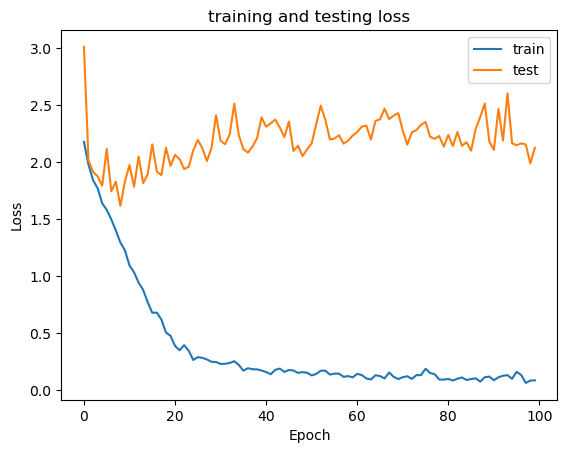

In [14]:
y = loss_res_train_list
y_test=loss_res_test_list
plt.title('training and testing loss')
plt.plot(y,label='train')
plt.plot(y_test, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

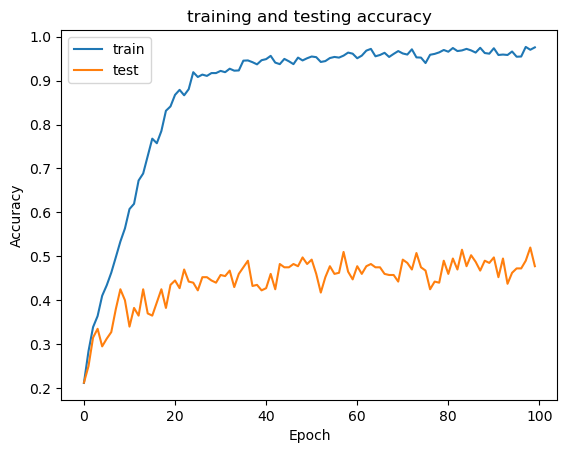

In [15]:
y =acc_res_train_list
y_test=acc_res_test_list
plt.title('training and testing accuracy')
plt.plot(y,label='train')
plt.plot(y_test, label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

2.(b)

In [16]:
class Resnet18_noidet(nn.Module):
        def __init__(self):
            super(Resnet18_noidet, self).__init__()
            self.cov1=nn.Sequential(
                 nn.Conv2d(3,64,3,1,1),
                 nn.BatchNorm2d(64),
                 nn.ReLU(),
                 nn.AvgPool2d(2,2)

            )
            self.res=nn.Sequential(
                 nn.Conv2d(64,64,3,1,1),
                 nn.BatchNorm2d(64),
                 nn.ReLU(),
                 nn.Conv2d(64,64,3,1,1),
                 nn.BatchNorm2d(64),
                 nn.ReLU()
            )
            self.res2=nn.Sequential(
                 nn.Conv2d(64,128,3,2,1),
                 nn.BatchNorm2d(128),
                 nn.ReLU(),
                 nn.Conv2d(128,128,3,1,1),
                 nn.BatchNorm2d(128),
                 nn.ReLU()
            )
            self.res3=nn.Sequential(
                 nn.Conv2d(128,128,3,1,1),
                 nn.BatchNorm2d(128),
                 nn.ReLU(),
                 nn.Conv2d(128,128,3,1,1),
                 nn.BatchNorm2d(128),
                 nn.ReLU()
            )
            self.res4=nn.Sequential(
                 nn.Conv2d(128,256,3,2,1),
                 nn.BatchNorm2d(256),
                 nn.ReLU(),
                 nn.Conv2d(256,256,3,1,1),
                 nn.BatchNorm2d(256),
                 nn.ReLU()
            )
            self.res5=nn.Sequential(
                 nn.Conv2d(256,256,3,1,1),
                 nn.BatchNorm2d(256),
                 nn.ReLU(),
                 nn.Conv2d(256,256,3,1,1),
                 nn.BatchNorm2d(256),
                 nn.ReLU()
            )
            self.res6=nn.Sequential(
                 nn.Conv2d(256,512,3,2,1),
                 nn.BatchNorm2d(512),
                 nn.ReLU(),
                 nn.Conv2d(512,512,3,1,1),
                 nn.BatchNorm2d(512),
                 nn.ReLU()
            )
            self.res7=nn.Sequential(
                 nn.Conv2d(512,512,3,1,1),
                 nn.BatchNorm2d(512),
                 nn.ReLU(),
                 
                 nn.Conv2d(512,512,3,1,1),
                 nn.BatchNorm2d(512),
                 nn.ReLU(),
                 nn.AvgPool2d(2,2)
            )
            self.change_shape1=nn.Sequential(
                 nn.Conv2d(64,128,3,2,1),
                 nn.BatchNorm2d(128)
            )
            self.change_shape2=nn.Sequential(
                 nn.Conv2d(128,256,3,2,1),
                 nn.BatchNorm2d(256)
            )
            self.change_shape3=nn.Sequential(
                 nn.Conv2d(256,512,3,2,1),
                 nn.BatchNorm2d(512),
                 
            )
            self.change_shape4=nn.Sequential(
                 nn.Conv2d(512,512,3,2,1),
                 nn.BatchNorm2d(512),
                 
            )
            
            self.fc=nn.Sequential(
                 nn.Dropout(0.2),
                 nn.Linear(512,10),

            )
        def forward(self, x):
            x=self.cov1(x)
            #layer1
            #cut=x
            x=self.res(x)
            #x=x+cut
            x=F.relu(x)
            #cut=x
            x=self.res(x)
            #x=x+cut
            x=F.relu(x)
            #cut=x
            #print('layer1 output:',cut.shape)
            #layer2
            x=self.res2(x)
            #cut=self.change_shape1(cut)
            #x=x+cut
            x=F.relu(x)
            #cut=x
            x=self.res3(x)
            #x=x+cut
            x=F.relu(x)
            #cut=x
            #print('layer2 output:',cut.shape)
            #layer3
            x=self.res4(x)
            #cut=self.change_shape2(cut)
            #x=x+cut
            x=F.relu(x)
            #cut=x
            x=self.res5(x)
            #x=x+cut
            x=F.relu(x)
            #cut=x
            #print('layer3 output:',cut.shape)
            #layer4
            x=self.res6(x)
            #cut=self.change_shape3(cut)
            #x=x+cut
            x=F.relu(x)
            #cut=x
            x=self.res7(x)
            #cut=self.change_shape4(cut)
            #x=x+cut
            x=F.relu(x)
            #print('layer4 output:',cut.shape)
            ##fc
            x=x.view(x.size(0),-1)
            x=self.fc(x)

            return x

In [17]:
model_res_noidet=Resnet18_noidet()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_res_noidet.to(device)
optimizer = torch.optim.Adam(model_res_noidet.parameters(),lr=0.001,weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

In [18]:
num_epochs=100
loss_res_no_train_list=[]
loss_res_no_test_list=[]
acc_res_no_train_list=[]
acc_res_no_test_list=[]
for i in range(num_epochs):
    loss_res_no_train,acc_res_no_train=train(i,num_epochs,model_res_noidet)
    loss_res_no_train_list.append(loss_res_no_train)
    acc_res_no_train_list.append(acc_res_no_train)

    loss_res_no_test,acc_res_no_test=test(model_res_noidet)
    loss_res_no_test_list.append(loss_res_no_test)
    acc_res_no_test_list.append(acc_res_no_test)

epoch[  1/100]|Training: 100%|██████████| 63/63 [00:07<00:00,  8.42it/s,  loss 2.0454 accuracy 0.1553]
100%|██████████| 13/13 [00:00<00:00, 25.10it/s]


accuracy:  0.185


epoch[  2/100]|Training: 100%|██████████| 63/63 [00:06<00:00,  9.39it/s,  loss 2.0561 accuracy 0.2049]
100%|██████████| 13/13 [00:00<00:00, 25.68it/s]


accuracy:  0.2025


epoch[  3/100]|Training: 100%|██████████| 63/63 [00:06<00:00,  9.12it/s,  loss 1.9533 accuracy 0.2212]
100%|██████████| 13/13 [00:00<00:00, 29.29it/s]


accuracy:  0.22


epoch[  4/100]|Training: 100%|██████████| 63/63 [00:05<00:00, 11.75it/s,  loss 2.0114 accuracy 0.2381]
100%|██████████| 13/13 [00:00<00:00, 28.97it/s]


accuracy:  0.245


epoch[  5/100]|Training: 100%|██████████| 63/63 [00:05<00:00, 11.57it/s,  loss 2.0764 accuracy 0.2465]
100%|██████████| 13/13 [00:00<00:00, 29.89it/s]


accuracy:  0.2375


epoch[  6/100]|Training: 100%|██████████| 63/63 [00:05<00:00, 11.75it/s,  loss 1.8475 accuracy 0.2793]
100%|██████████| 13/13 [00:00<00:00, 28.65it/s]


accuracy:  0.2375


epoch[  7/100]|Training: 100%|██████████| 63/63 [00:07<00:00,  8.30it/s,  loss 1.9142 accuracy 0.2922]
100%|██████████| 13/13 [00:00<00:00, 24.75it/s]


accuracy:  0.2575


epoch[  8/100]|Training: 100%|██████████| 63/63 [00:06<00:00,  9.83it/s,  loss 2.1683 accuracy 0.2966]
100%|██████████| 13/13 [00:00<00:00, 24.24it/s]


accuracy:  0.3025


epoch[  9/100]|Training: 100%|██████████| 63/63 [00:05<00:00, 12.41it/s,  loss 1.6049 accuracy 0.2917]
100%|██████████| 13/13 [00:00<00:00, 19.57it/s]


accuracy:  0.245


epoch[ 10/100]|Training: 100%|██████████| 63/63 [00:05<00:00, 12.08it/s,  loss 2.3330 accuracy 0.3100]
100%|██████████| 13/13 [00:00<00:00, 30.11it/s]


accuracy:  0.2675


epoch[ 11/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.22it/s,  loss 1.6871 accuracy 0.3462]
100%|██████████| 13/13 [00:00<00:00, 30.95it/s]


accuracy:  0.29


epoch[ 12/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.04it/s,  loss 1.8007 accuracy 0.3358]
100%|██████████| 13/13 [00:00<00:00, 25.38it/s]


accuracy:  0.31


epoch[ 13/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 12.72it/s,  loss 1.7562 accuracy 0.3403]
100%|██████████| 13/13 [00:00<00:00, 30.79it/s]


accuracy:  0.335


epoch[ 14/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 12.86it/s,  loss 1.8021 accuracy 0.3358]
100%|██████████| 13/13 [00:00<00:00, 29.37it/s]


accuracy:  0.2975


epoch[ 15/100]|Training: 100%|██████████| 63/63 [00:05<00:00, 10.72it/s,  loss 1.6619 accuracy 0.3552]
100%|██████████| 13/13 [00:00<00:00, 24.87it/s]


accuracy:  0.33


epoch[ 16/100]|Training: 100%|██████████| 63/63 [00:05<00:00, 11.80it/s,  loss 2.0021 accuracy 0.3423]
100%|██████████| 13/13 [00:00<00:00, 26.63it/s]


accuracy:  0.3425


epoch[ 17/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 12.65it/s,  loss 1.7434 accuracy 0.3730]
100%|██████████| 13/13 [00:00<00:00, 28.03it/s]


accuracy:  0.3425


epoch[ 18/100]|Training: 100%|██████████| 63/63 [00:05<00:00, 12.52it/s,  loss 1.7287 accuracy 0.3760]
100%|██████████| 13/13 [00:00<00:00, 29.99it/s]


accuracy:  0.3175


epoch[ 19/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.01it/s,  loss 1.6750 accuracy 0.3869]
100%|██████████| 13/13 [00:00<00:00, 28.37it/s]


accuracy:  0.3125


epoch[ 20/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.33it/s,  loss 1.4473 accuracy 0.4196]
100%|██████████| 13/13 [00:00<00:00, 31.89it/s]


accuracy:  0.385


epoch[ 21/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.36it/s,  loss 1.5501 accuracy 0.4172]
100%|██████████| 13/13 [00:00<00:00, 31.30it/s]


accuracy:  0.34


epoch[ 22/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.04it/s,  loss 1.5835 accuracy 0.4196]
100%|██████████| 13/13 [00:00<00:00, 27.85it/s]


accuracy:  0.3375


epoch[ 23/100]|Training: 100%|██████████| 63/63 [00:05<00:00, 12.34it/s,  loss 1.7617 accuracy 0.4286]
100%|██████████| 13/13 [00:00<00:00, 30.33it/s]


accuracy:  0.3675


epoch[ 24/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.22it/s,  loss 1.9417 accuracy 0.4479]
100%|██████████| 13/13 [00:00<00:00, 32.18it/s]


accuracy:  0.33


epoch[ 25/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.32it/s,  loss 1.3025 accuracy 0.4380]
100%|██████████| 13/13 [00:00<00:00, 30.94it/s]


accuracy:  0.3175


epoch[ 26/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.32it/s,  loss 1.4127 accuracy 0.4702]
100%|██████████| 13/13 [00:00<00:00, 31.74it/s]


accuracy:  0.37


epoch[ 27/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.20it/s,  loss 1.4159 accuracy 0.4668]
100%|██████████| 13/13 [00:00<00:00, 31.36it/s]


accuracy:  0.3675


epoch[ 28/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.16it/s,  loss 1.2484 accuracy 0.4722]
100%|██████████| 13/13 [00:00<00:00, 31.52it/s]


accuracy:  0.405


epoch[ 29/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.40it/s,  loss 2.1049 accuracy 0.4826]
100%|██████████| 13/13 [00:00<00:00, 31.94it/s]


accuracy:  0.355


epoch[ 30/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.41it/s,  loss 1.7302 accuracy 0.4737]
100%|██████████| 13/13 [00:00<00:00, 31.41it/s]


accuracy:  0.375


epoch[ 31/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.38it/s,  loss 1.5771 accuracy 0.5164]
100%|██████████| 13/13 [00:00<00:00, 31.72it/s]


accuracy:  0.385


epoch[ 32/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.40it/s,  loss 1.1105 accuracy 0.5119]
100%|██████████| 13/13 [00:00<00:00, 31.97it/s]


accuracy:  0.405


epoch[ 33/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 12.94it/s,  loss 1.3187 accuracy 0.5456]
100%|██████████| 13/13 [00:00<00:00, 30.99it/s]


accuracy:  0.395


epoch[ 34/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.39it/s,  loss 1.1590 accuracy 0.5417]
100%|██████████| 13/13 [00:00<00:00, 31.43it/s]


accuracy:  0.3525


epoch[ 35/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.18it/s,  loss 1.4780 accuracy 0.5630]
100%|██████████| 13/13 [00:00<00:00, 31.36it/s]


accuracy:  0.3425


epoch[ 36/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.33it/s,  loss 1.4049 accuracy 0.5466]
100%|██████████| 13/13 [00:00<00:00, 30.99it/s]


accuracy:  0.3575


epoch[ 37/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.28it/s,  loss 1.0908 accuracy 0.5625]
100%|██████████| 13/13 [00:00<00:00, 30.82it/s]


accuracy:  0.435


epoch[ 38/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.12it/s,  loss 1.2545 accuracy 0.5893]
100%|██████████| 13/13 [00:00<00:00, 27.93it/s]


accuracy:  0.3775


epoch[ 39/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.33it/s,  loss 2.0968 accuracy 0.6017]
100%|██████████| 13/13 [00:00<00:00, 29.99it/s]


accuracy:  0.3875


epoch[ 40/100]|Training: 100%|██████████| 63/63 [00:05<00:00, 12.49it/s,  loss 1.3011 accuracy 0.5977]
100%|██████████| 13/13 [00:00<00:00, 23.47it/s]


accuracy:  0.3775


epoch[ 41/100]|Training: 100%|██████████| 63/63 [00:05<00:00, 12.29it/s,  loss 1.3688 accuracy 0.5962]
100%|██████████| 13/13 [00:00<00:00, 31.11it/s]


accuracy:  0.395


epoch[ 42/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.00it/s,  loss 1.3471 accuracy 0.6186]
100%|██████████| 13/13 [00:00<00:00, 30.60it/s]


accuracy:  0.4075


epoch[ 43/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.39it/s,  loss 1.0708 accuracy 0.6190]
100%|██████████| 13/13 [00:00<00:00, 31.90it/s]


accuracy:  0.415


epoch[ 44/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 12.76it/s,  loss 1.5283 accuracy 0.6270]
100%|██████████| 13/13 [00:00<00:00, 27.93it/s]


accuracy:  0.39


epoch[ 45/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 12.66it/s,  loss 0.8299 accuracy 0.6642]
100%|██████████| 13/13 [00:00<00:00, 24.00it/s]


accuracy:  0.4175


epoch[ 46/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 12.91it/s,  loss 2.0226 accuracy 0.6567]
100%|██████████| 13/13 [00:00<00:00, 31.12it/s]


accuracy:  0.41


epoch[ 47/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 12.97it/s,  loss 0.9017 accuracy 0.6736]
100%|██████████| 13/13 [00:00<00:00, 30.27it/s]


accuracy:  0.385


epoch[ 48/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 12.67it/s,  loss 0.8698 accuracy 0.6895]
100%|██████████| 13/13 [00:00<00:00, 22.42it/s]


accuracy:  0.435


epoch[ 49/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.08it/s,  loss 0.5252 accuracy 0.7078]
100%|██████████| 13/13 [00:00<00:00, 26.90it/s]


accuracy:  0.4375


epoch[ 50/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 12.99it/s,  loss 1.3415 accuracy 0.7009]
100%|██████████| 13/13 [00:00<00:00, 31.72it/s]


accuracy:  0.43


epoch[ 51/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 12.80it/s,  loss 1.0661 accuracy 0.7039]
100%|██████████| 13/13 [00:00<00:00, 31.48it/s]


accuracy:  0.4425


epoch[ 52/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.48it/s,  loss 1.1340 accuracy 0.7530]
100%|██████████| 13/13 [00:00<00:00, 31.43it/s]


accuracy:  0.425


epoch[ 53/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 12.74it/s,  loss 0.8271 accuracy 0.6959]
100%|██████████| 13/13 [00:00<00:00, 29.26it/s]


accuracy:  0.4075


epoch[ 54/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 12.95it/s,  loss 1.0144 accuracy 0.7391]
100%|██████████| 13/13 [00:00<00:00, 27.65it/s]


accuracy:  0.4625


epoch[ 55/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.27it/s,  loss 0.5741 accuracy 0.7460]
100%|██████████| 13/13 [00:00<00:00, 28.65it/s]


accuracy:  0.4375


epoch[ 56/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.14it/s,  loss 0.4659 accuracy 0.7614]
100%|██████████| 13/13 [00:00<00:00, 27.40it/s]


accuracy:  0.4725


epoch[ 57/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.31it/s,  loss 1.0785 accuracy 0.7941]
100%|██████████| 13/13 [00:00<00:00, 29.64it/s]


accuracy:  0.45


epoch[ 58/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.03it/s,  loss 0.8901 accuracy 0.7773]
100%|██████████| 13/13 [00:00<00:00, 31.20it/s]


accuracy:  0.4475


epoch[ 59/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.23it/s,  loss 0.4065 accuracy 0.7837]
100%|██████████| 13/13 [00:00<00:00, 27.06it/s]


accuracy:  0.43


epoch[ 60/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 12.64it/s,  loss 1.3592 accuracy 0.7817]
100%|██████████| 13/13 [00:00<00:00, 29.29it/s]


accuracy:  0.42


epoch[ 61/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.16it/s,  loss 0.2947 accuracy 0.8165]
100%|██████████| 13/13 [00:00<00:00, 31.12it/s]


accuracy:  0.435


epoch[ 62/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.39it/s,  loss 0.8665 accuracy 0.7981]
100%|██████████| 13/13 [00:00<00:00, 32.22it/s]


accuracy:  0.4625


epoch[ 63/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.44it/s,  loss 0.5094 accuracy 0.8264]
100%|██████████| 13/13 [00:00<00:00, 31.69it/s]


accuracy:  0.415


epoch[ 64/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.31it/s,  loss 0.4356 accuracy 0.8304]
100%|██████████| 13/13 [00:00<00:00, 30.67it/s]


accuracy:  0.435


epoch[ 65/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.25it/s,  loss 0.5863 accuracy 0.7971]
100%|██████████| 13/13 [00:00<00:00, 30.32it/s]


accuracy:  0.4


epoch[ 66/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.20it/s,  loss 0.3061 accuracy 0.8125]
100%|██████████| 13/13 [00:00<00:00, 30.09it/s]


accuracy:  0.38


epoch[ 67/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.17it/s,  loss 0.9470 accuracy 0.8309]
100%|██████████| 13/13 [00:00<00:00, 30.85it/s]


accuracy:  0.4325


epoch[ 68/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.06it/s,  loss 0.7020 accuracy 0.8457]
100%|██████████| 13/13 [00:00<00:00, 31.08it/s]


accuracy:  0.4625


epoch[ 69/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.14it/s,  loss 0.3276 accuracy 0.8472]
100%|██████████| 13/13 [00:00<00:00, 31.08it/s]


accuracy:  0.4475


epoch[ 70/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 12.99it/s,  loss 0.3498 accuracy 0.8661]
100%|██████████| 13/13 [00:00<00:00, 30.38it/s]


accuracy:  0.4575


epoch[ 71/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.06it/s,  loss 0.8036 accuracy 0.8616]
100%|██████████| 13/13 [00:00<00:00, 30.72it/s]


accuracy:  0.46


epoch[ 72/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.02it/s,  loss 0.8051 accuracy 0.8408]
100%|██████████| 13/13 [00:00<00:00, 31.59it/s]


accuracy:  0.405


epoch[ 73/100]|Training: 100%|██████████| 63/63 [00:04<00:00, 13.25it/s,  loss 0.3398 accuracy 0.8562]
100%|██████████| 13/13 [00:00<00:00, 32.06it/s]


accuracy:  0.4475


epoch[ 74/100]|Training: 100%|██████████| 63/63 [00:05<00:00, 11.82it/s,  loss 0.7391 accuracy 0.8760]
100%|██████████| 13/13 [00:00<00:00, 24.93it/s]


accuracy:  0.4175


epoch[ 75/100]|Training: 100%|██████████| 63/63 [00:06<00:00, 10.37it/s,  loss 0.1062 accuracy 0.8745]
100%|██████████| 13/13 [00:00<00:00, 23.77it/s]


accuracy:  0.465


epoch[ 76/100]|Training: 100%|██████████| 63/63 [00:06<00:00, 10.04it/s,  loss 0.3193 accuracy 0.8676]
100%|██████████| 13/13 [00:00<00:00, 22.93it/s]


accuracy:  0.4425


epoch[ 77/100]|Training: 100%|██████████| 63/63 [00:06<00:00, 10.11it/s,  loss 0.3922 accuracy 0.8690]
100%|██████████| 13/13 [00:00<00:00, 26.11it/s]


accuracy:  0.4525


epoch[ 78/100]|Training: 100%|██████████| 63/63 [00:06<00:00, 10.30it/s,  loss 0.4274 accuracy 0.8819]
100%|██████████| 13/13 [00:00<00:00, 19.58it/s]


accuracy:  0.4325


epoch[ 79/100]|Training: 100%|██████████| 63/63 [00:06<00:00, 10.24it/s,  loss 0.3430 accuracy 0.8869]
100%|██████████| 13/13 [00:00<00:00, 24.51it/s]


accuracy:  0.445


epoch[ 80/100]|Training: 100%|██████████| 63/63 [00:05<00:00, 10.67it/s,  loss 0.6050 accuracy 0.8894]
100%|██████████| 13/13 [00:00<00:00, 25.75it/s]


accuracy:  0.37


epoch[ 81/100]|Training: 100%|██████████| 63/63 [00:06<00:00, 10.30it/s,  loss 0.4437 accuracy 0.8641]
100%|██████████| 13/13 [00:00<00:00, 25.75it/s]


accuracy:  0.49


epoch[ 82/100]|Training: 100%|██████████| 63/63 [00:05<00:00, 10.54it/s,  loss 0.6488 accuracy 0.8909]
100%|██████████| 13/13 [00:00<00:00, 22.15it/s]


accuracy:  0.4525


epoch[ 83/100]|Training: 100%|██████████| 63/63 [00:06<00:00,  9.70it/s,  loss 0.1770 accuracy 0.8810]
100%|██████████| 13/13 [00:00<00:00, 25.26it/s]


accuracy:  0.47


epoch[ 84/100]|Training: 100%|██████████| 63/63 [00:05<00:00, 10.64it/s,  loss 0.3490 accuracy 0.9023]
100%|██████████| 13/13 [00:00<00:00, 24.14it/s]


accuracy:  0.43


epoch[ 85/100]|Training: 100%|██████████| 63/63 [00:06<00:00, 10.47it/s,  loss 0.0968 accuracy 0.9122]
100%|██████████| 13/13 [00:00<00:00, 25.34it/s]


accuracy:  0.4625


epoch[ 86/100]|Training: 100%|██████████| 63/63 [00:05<00:00, 10.59it/s,  loss 0.8705 accuracy 0.8899]
100%|██████████| 13/13 [00:00<00:00, 23.69it/s]


accuracy:  0.47


epoch[ 87/100]|Training: 100%|██████████| 63/63 [00:05<00:00, 10.60it/s,  loss 0.5660 accuracy 0.8844]
100%|██████████| 13/13 [00:00<00:00, 25.85it/s]


accuracy:  0.4525


epoch[ 88/100]|Training: 100%|██████████| 63/63 [00:06<00:00, 10.47it/s,  loss 0.2253 accuracy 0.8993]
100%|██████████| 13/13 [00:00<00:00, 26.27it/s]


accuracy:  0.4925


epoch[ 89/100]|Training: 100%|██████████| 63/63 [00:05<00:00, 10.73it/s,  loss 0.4307 accuracy 0.9122]
100%|██████████| 13/13 [00:00<00:00, 26.38it/s]


accuracy:  0.495


epoch[ 90/100]|Training: 100%|██████████| 63/63 [00:05<00:00, 10.56it/s,  loss 0.3002 accuracy 0.9157]
100%|██████████| 13/13 [00:00<00:00, 25.66it/s]


accuracy:  0.4525


epoch[ 91/100]|Training: 100%|██████████| 63/63 [00:06<00:00, 10.35it/s,  loss 0.2122 accuracy 0.9048]
100%|██████████| 13/13 [00:00<00:00, 23.38it/s]


accuracy:  0.44


epoch[ 92/100]|Training: 100%|██████████| 63/63 [00:05<00:00, 10.60it/s,  loss 0.7455 accuracy 0.9122]
100%|██████████| 13/13 [00:00<00:00, 25.07it/s]


accuracy:  0.4475


epoch[ 93/100]|Training: 100%|██████████| 63/63 [00:05<00:00, 10.78it/s,  loss 0.0315 accuracy 0.9067]
100%|██████████| 13/13 [00:00<00:00, 25.63it/s]


accuracy:  0.4625


epoch[ 94/100]|Training: 100%|██████████| 63/63 [00:06<00:00,  9.52it/s,  loss 0.0415 accuracy 0.9286]
100%|██████████| 13/13 [00:00<00:00, 22.33it/s]


accuracy:  0.4525


epoch[ 95/100]|Training: 100%|██████████| 63/63 [00:05<00:00, 10.92it/s,  loss 0.1117 accuracy 0.9286]
100%|██████████| 13/13 [00:00<00:00, 25.91it/s]


accuracy:  0.44


epoch[ 96/100]|Training: 100%|██████████| 63/63 [00:05<00:00, 10.79it/s,  loss 1.7619 accuracy 0.9087]
100%|██████████| 13/13 [00:00<00:00, 25.90it/s]


accuracy:  0.5025


epoch[ 97/100]|Training: 100%|██████████| 63/63 [00:05<00:00, 10.77it/s,  loss 0.2907 accuracy 0.9097]
100%|██████████| 13/13 [00:00<00:00, 26.88it/s]


accuracy:  0.4425


epoch[ 98/100]|Training: 100%|██████████| 63/63 [00:05<00:00, 10.70it/s,  loss 0.4374 accuracy 0.9226]
100%|██████████| 13/13 [00:00<00:00, 26.10it/s]


accuracy:  0.4325


epoch[ 99/100]|Training: 100%|██████████| 63/63 [00:05<00:00, 10.51it/s,  loss 0.1625 accuracy 0.8943]
100%|██████████| 13/13 [00:00<00:00, 27.35it/s]


accuracy:  0.4975


epoch[100/100]|Training: 100%|██████████| 63/63 [00:06<00:00, 10.37it/s,  loss 0.5353 accuracy 0.9082]
100%|██████████| 13/13 [00:00<00:00, 25.77it/s]

accuracy:  0.48


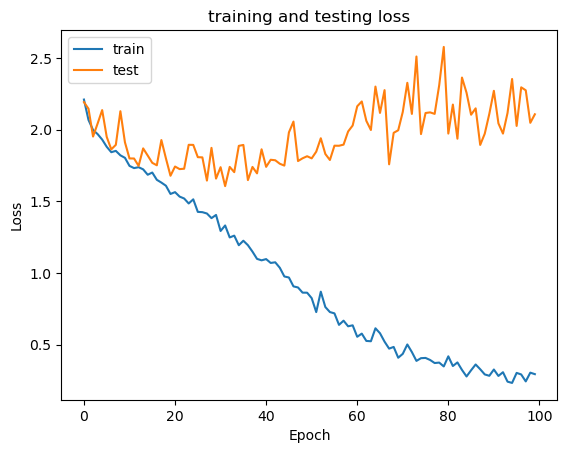

In [19]:
y = loss_res_no_train_list
y_test=loss_res_no_test_list
plt.title('training and testing loss')
plt.plot(y,label='train')
plt.plot(y_test, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

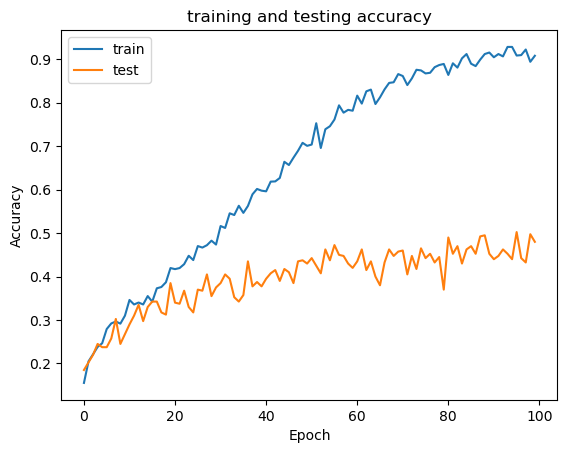

In [20]:
y =acc_res_no_train_list
y_test=acc_res_no_test_list
plt.title('training and testing accuracy')
plt.plot(y,label='train')
plt.plot(y_test, label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

沒有使用 identity mapping會造成梯度消失，導致模型訓練得很慢，甚至訓練不起來，loss無法下降，accuracy無法上升。